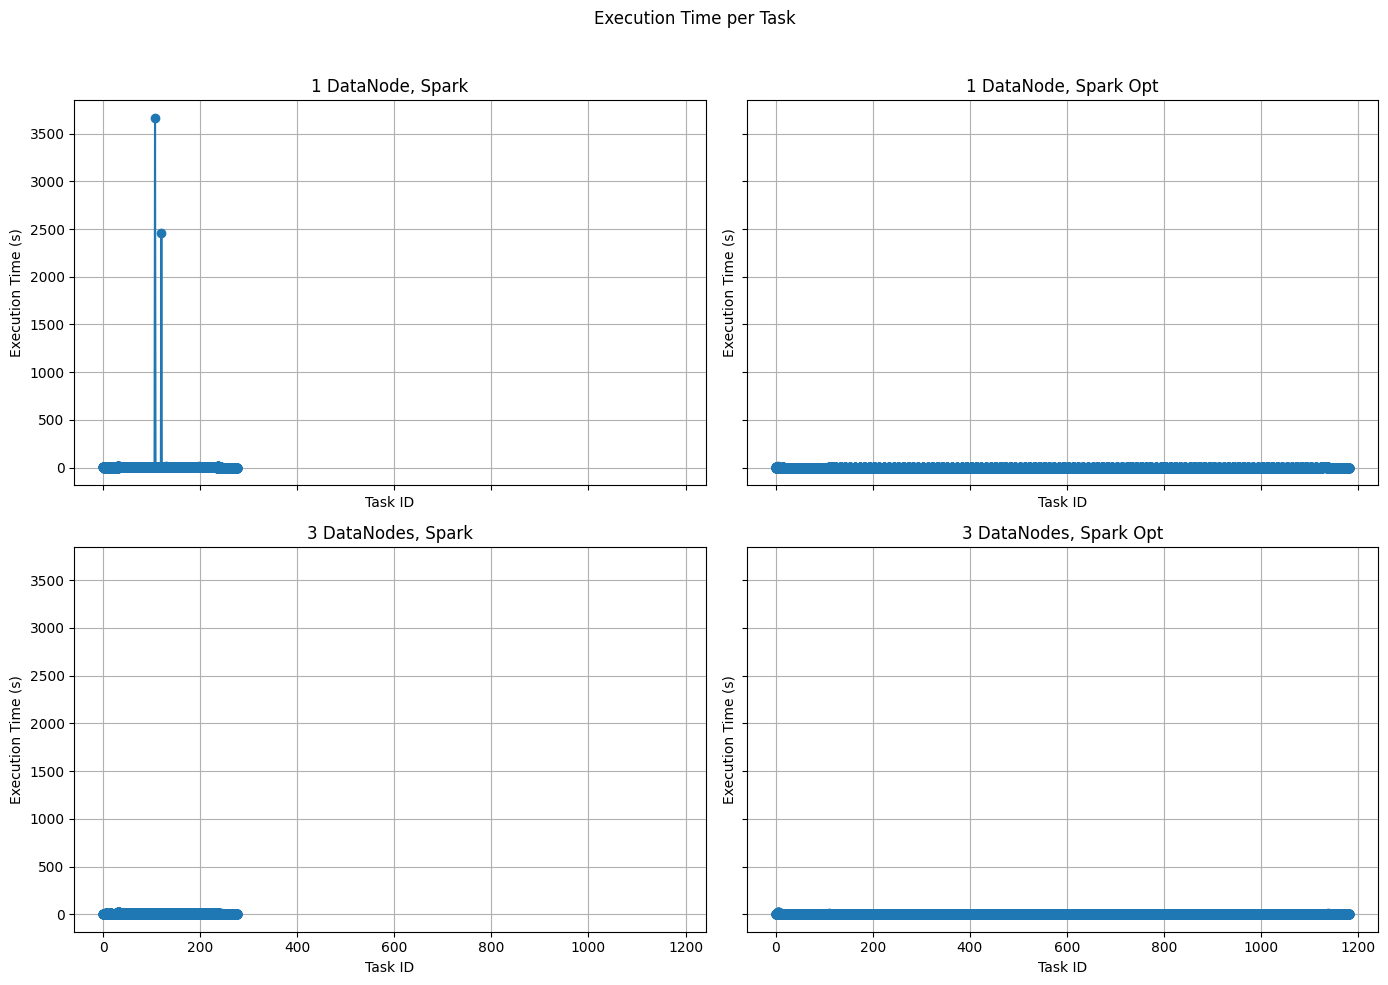

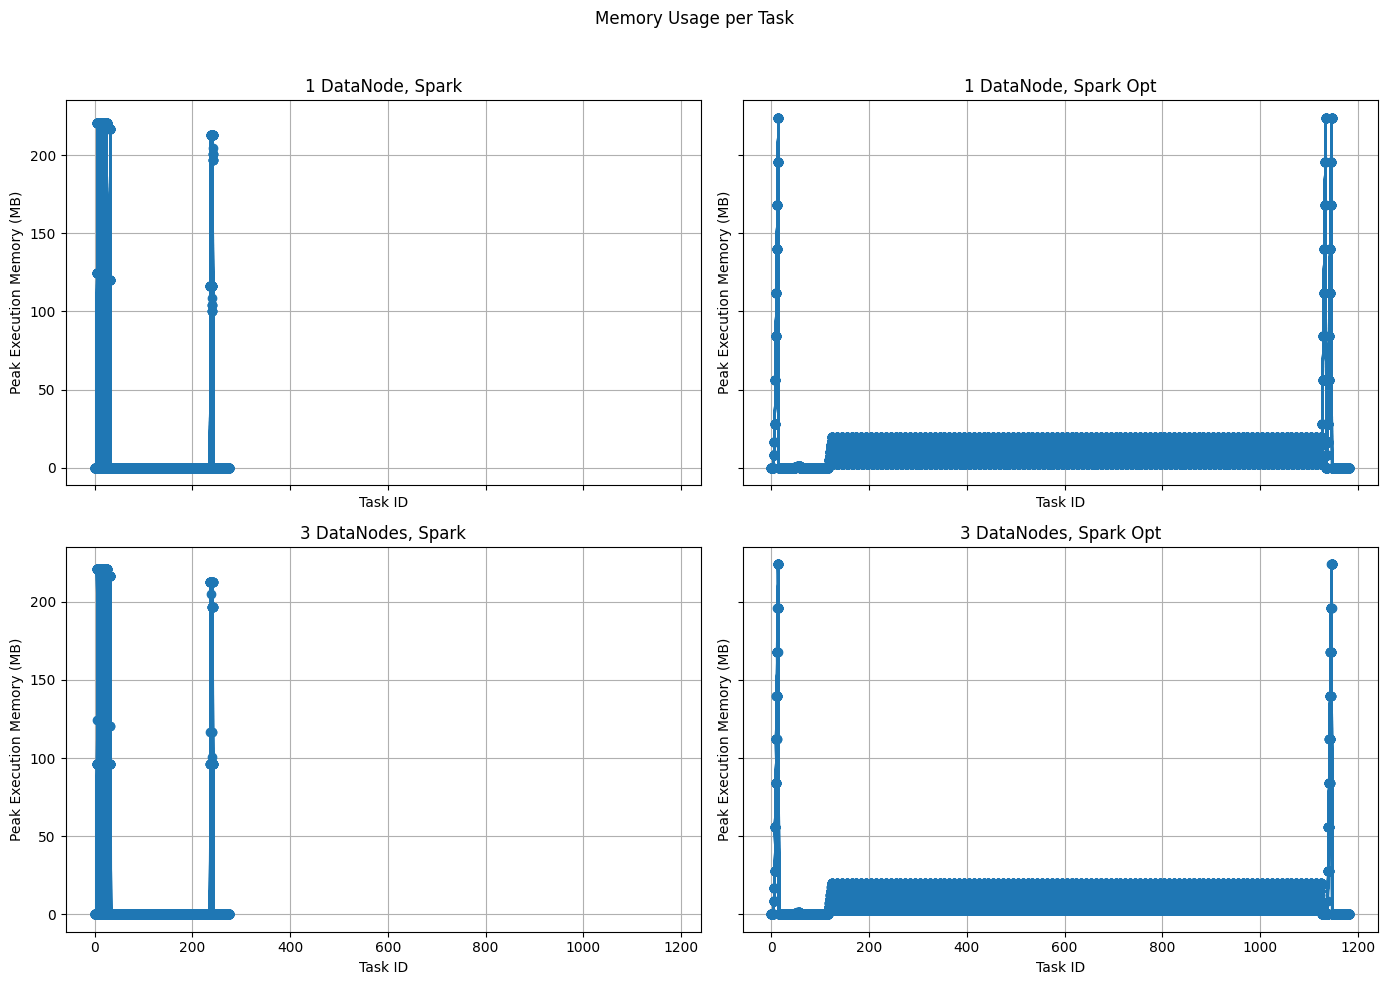

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path to the folder containing the log files
log_folders = {
    '1 DataNode, Spark': 'logs/1NodeSpark',
    '1 DataNode, Spark Opt': 'logs/1NodeSparkOpt',
    '3 DataNodes, Spark': 'logs/3NoodeSpark',
    '3 DataNodes, Spark Opt': 'logs/3NoodeSparkOpt'
}

# Initialize a dictionary to store the dataframes for each experiment
dfs = {}

# Function to extract and process log data
def process_log(file_path):
    task_ids = []
    launch_times = []
    finish_times = []
    peak_execution_memory = []
    
    with open(file_path, 'r', errors='ignore') as file:
        log_lines = file.readlines()
    
    for line in log_lines:
        try:
            data = json.loads(line.strip())
            if data['Event'] == 'SparkListenerTaskEnd':
                task_info = data['Task Info']
                metrics = {acc['Name']: acc['Value'] for acc in task_info.get('Accumulables', [])}
                task_ids.append(task_info['Task ID'])
                launch_times.append(task_info['Launch Time'])
                finish_times.append(task_info['Finish Time'])
                peak_execution_memory.append(metrics.get('internal.metrics.peakExecutionMemory', 0))
        except (json.JSONDecodeError, KeyError):
            continue

    launch_times = pd.to_datetime(launch_times, unit='ms')
    finish_times = pd.to_datetime(finish_times, unit='ms')
    execution_times = (finish_times - launch_times).total_seconds()
    
    df = pd.DataFrame({
        'Task ID': task_ids,
        'Launch Time': launch_times,
        'Finish Time': finish_times,
        'Execution Time (s)': execution_times,
        'Peak Execution Memory (MB)': [mem / (1024 * 1024) for mem in peak_execution_memory]  # Convert bytes to MB
    })
    
    return df

# Process each log file and store the dataframes
for experiment, folder_path in log_folders.items():
    all_dfs = []
    for log_file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, log_file)
        all_dfs.append(process_log(file_path))
    dfs[experiment] = pd.concat(all_dfs, ignore_index=True)

# Plot the execution time for each experiment
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
fig.suptitle('Execution Time per Task')

for ax, (experiment, df) in zip(axes.flatten(), dfs.items()):
    ax.plot(df['Task ID'], df['Execution Time (s)'], marker='o', linestyle='-')
    ax.set_title(experiment)
    ax.set_xlabel('Task ID')
    ax.set_ylabel('Execution Time (s)')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot the memory usage for each experiment
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
fig.suptitle('Memory Usage per Task')

for ax, (experiment, df) in zip(axes.flatten(), dfs.items()):
    ax.plot(df['Task ID'], df['Peak Execution Memory (MB)'], marker='o', linestyle='-')
    ax.set_title(experiment)
    ax.set_xlabel('Task ID')
    ax.set_ylabel('Peak Execution Memory (MB)')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
